In [8]:
import porespy as ps
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import glob

from skimage import io, filters, morphology, measure, exposure, segmentation, feature, util
from skimage.filters import threshold_otsu, threshold_li, threshold_triangle, rank
from scipy import ndimage as ndi

ps.visualization.set_mpl_style()

Found 100 slices
Stack shape: (100, 1100, 1100) dtype: float64


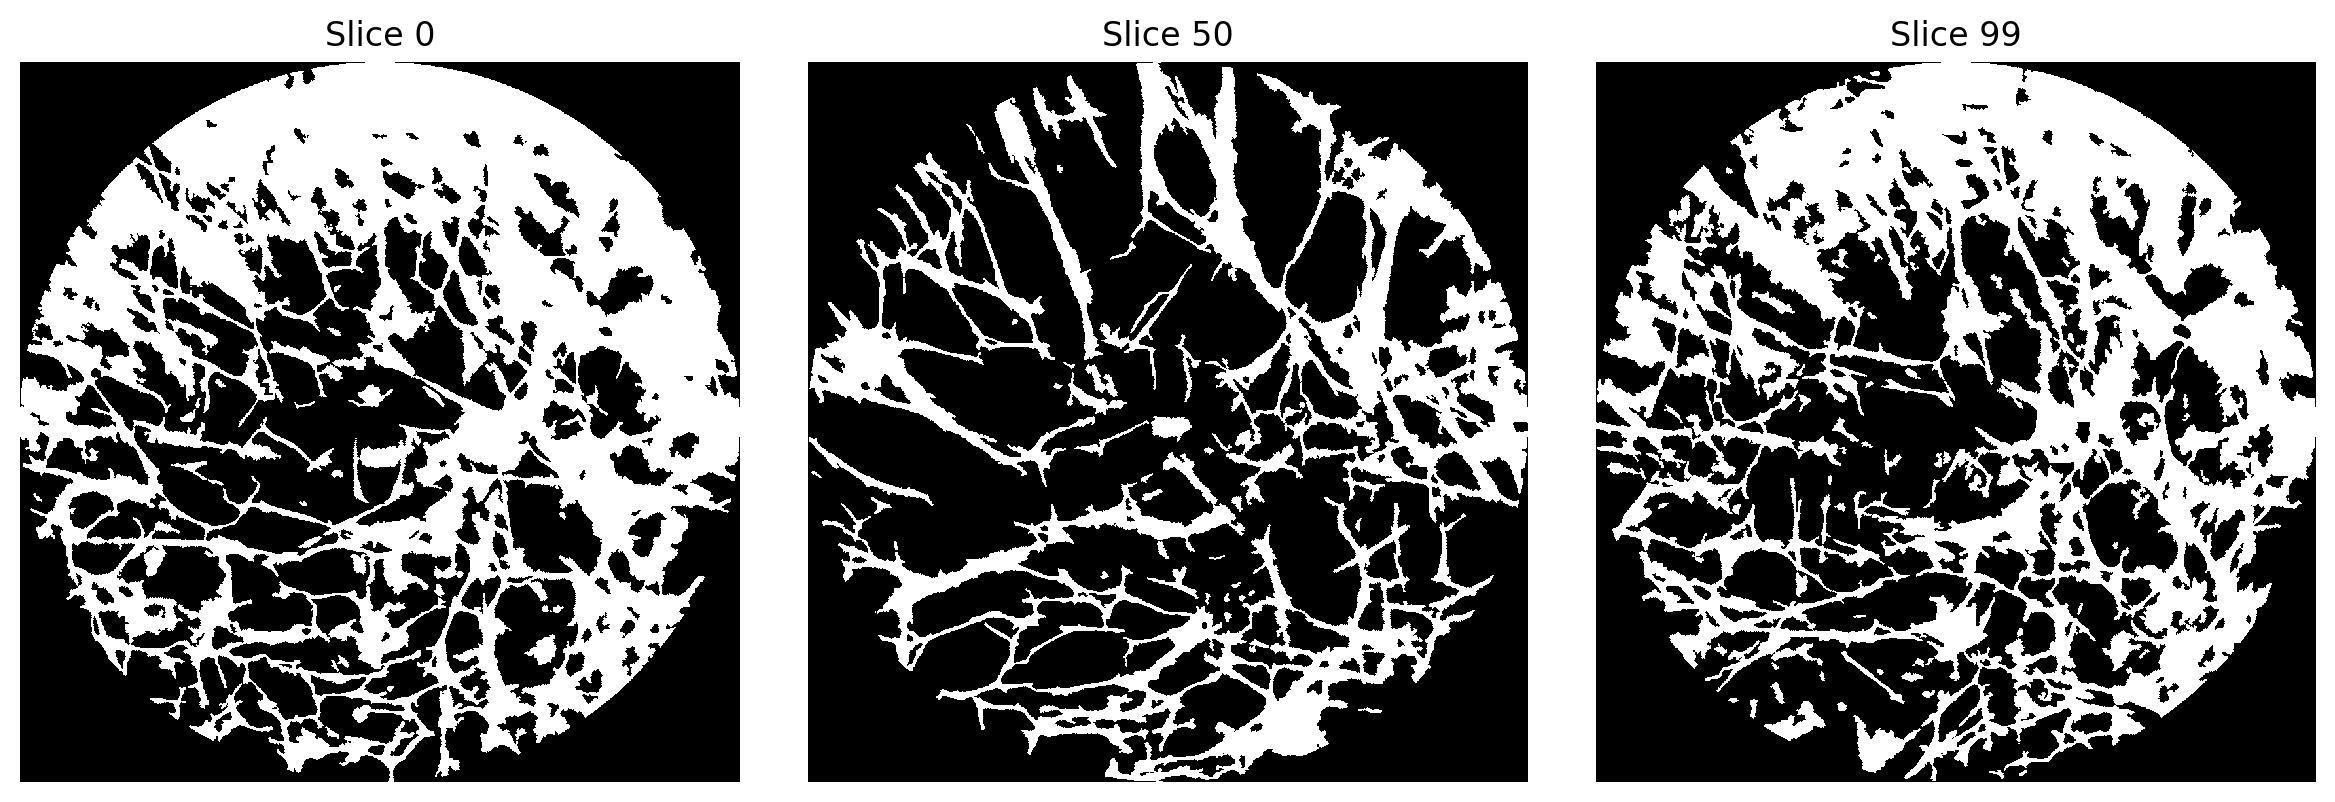

In [16]:
DATA_DIR = Path("/mnt/bgfs/projects/tomo_nano/joana/data/train_data/masks_100")  # <-- TODO: set this
PATTERN = "*.png"                        # e.g., '*.tif' or '*.png'
READ_AS_FLOAT = True                     # convert to float in [0, 1]

# Optional: restrict to a subset for quicker iteration (e.g., every 5th slice)
#STRIDE = 3      # use 1 for all slices
N_SLICES = 100

# ---- Load file list ----
files = sorted(DATA_DIR.glob(PATTERN))
n = len(files)
# if MAX_SLICES is not None:
#     files = files[:MAX_SLICES]
# files = files[::STRIDE]

indices = np.linspace(0, n - 1, N_SLICES, dtype=int)
files = [files[i] for i in indices]
print(f"Found {len(files)} slices")

# ---- Load stack ----
if len(files) == 0:
    raise FileNotFoundError("No files found. Check DATA_DIR and PATTERN.")

stack = io.imread_collection([str(f) for f in files]).concatenate()
if READ_AS_FLOAT:
    stack = util.img_as_float(stack)

print("Stack shape:", stack.shape, "dtype:", stack.dtype)

# Quick peek
mid = stack.shape[0] // 2
fig, axes = plt.subplots(1,3, figsize=(12,4))
axes[0].imshow(stack[0], cmap="gray"); axes[0].set_title(f"Slice {indices[0]}"); axes[0].axis("off")
axes[1].imshow(stack[mid], cmap="gray"); axes[1].set_title(f"Slice {indices[mid]}"); axes[1].axis("off")
axes[2].imshow(stack[-1], cmap="gray"); axes[2].set_title(f"Slice {indices[-1]}"); axes[2].axis("off")
plt.show()


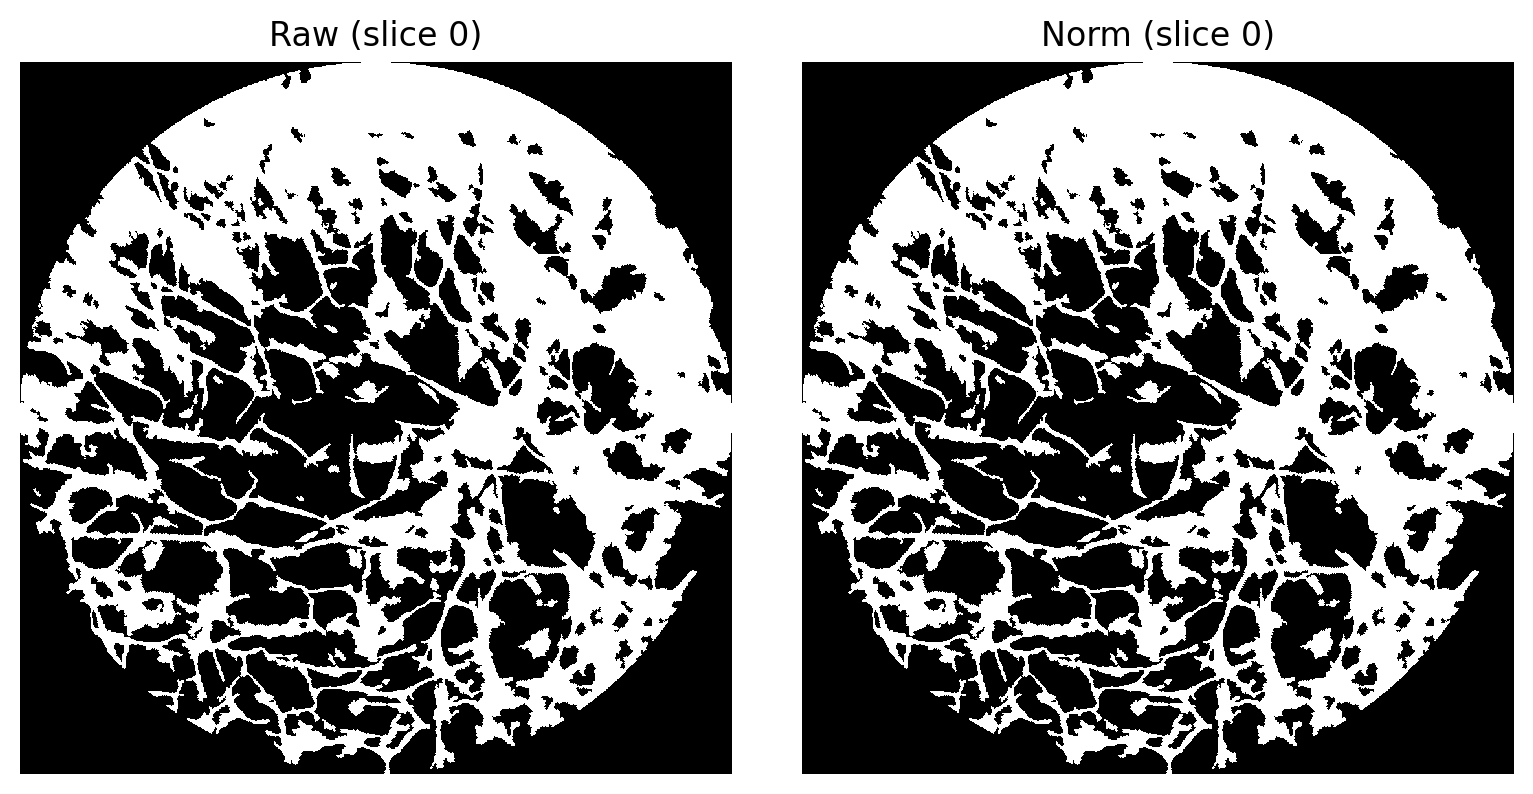

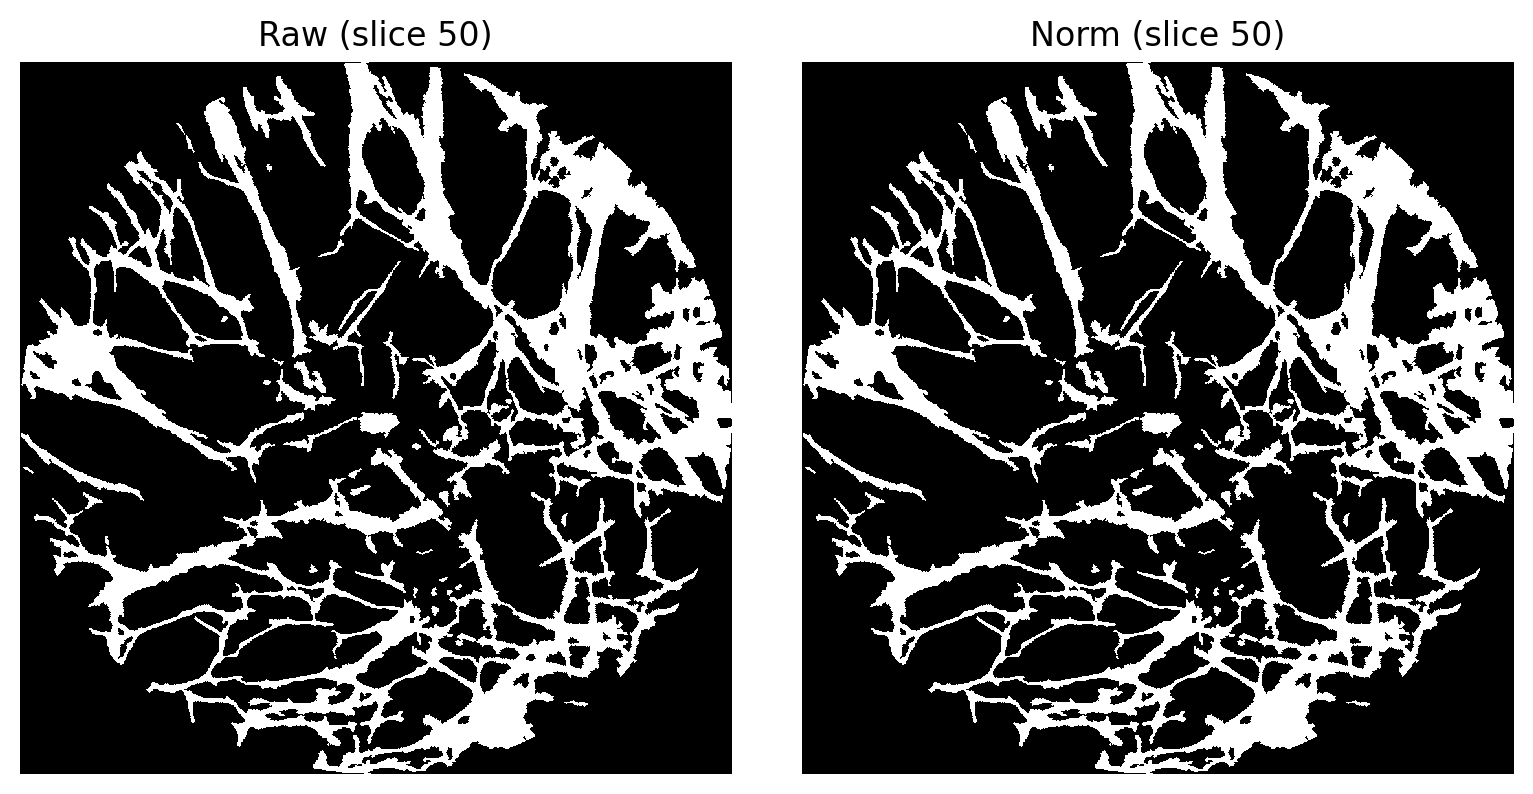

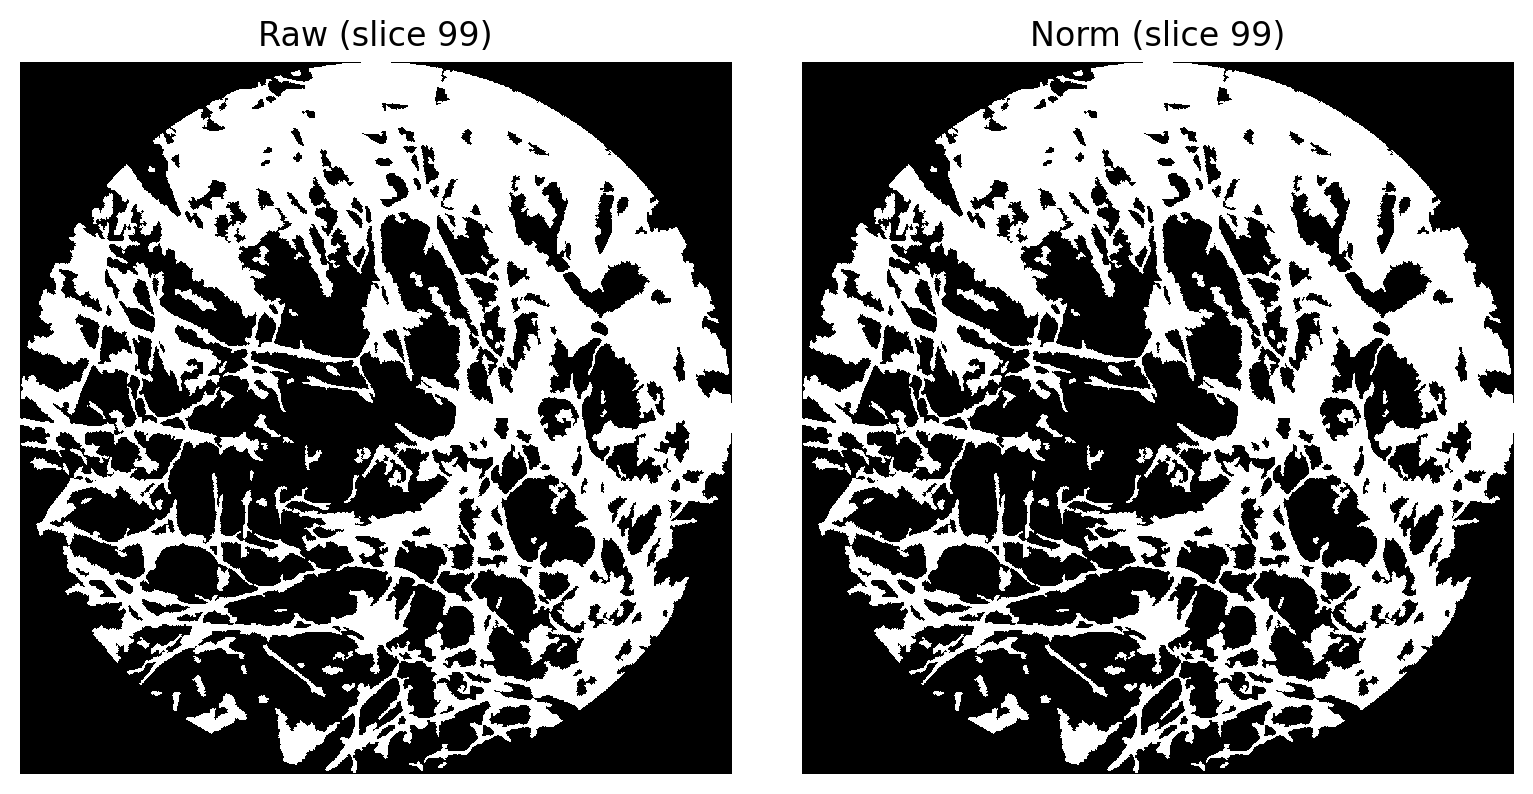

In [19]:
# Demo on a few slices
ids = [0, stack.shape[0]//2, stack.shape[0]-1]
for sid in ids:
    img = stack[sid]

    stack_min = stack.min()
    stack_max = stack.max()
    img_norm = (img - stack_min) / (stack_max - stack_min)
    
    fig, axes = plt.subplots(1,2, figsize=(8,4))
    axes[0].imshow(img, cmap="gray"); axes[0].set_title(f"Raw (slice {indices[sid]})"); axes[0].axis("off")
    axes[1].imshow(img_norm, cmap="gray"); axes[1].set_title(f"Norm (slice {indices[sid]})"); axes[1].axis("off")
    plt.show()

## Measuring fractal dimension by box-counting

Mede a complexidade e rugosidade das superfícies dos poros.
Teoricamente, quanto maior o valor, mais conectados os poros estão naquela região.

In [20]:
data = ps.metrics.boxcount(img)

  0%|          | 0/10 [00:00<?, ?it/s]

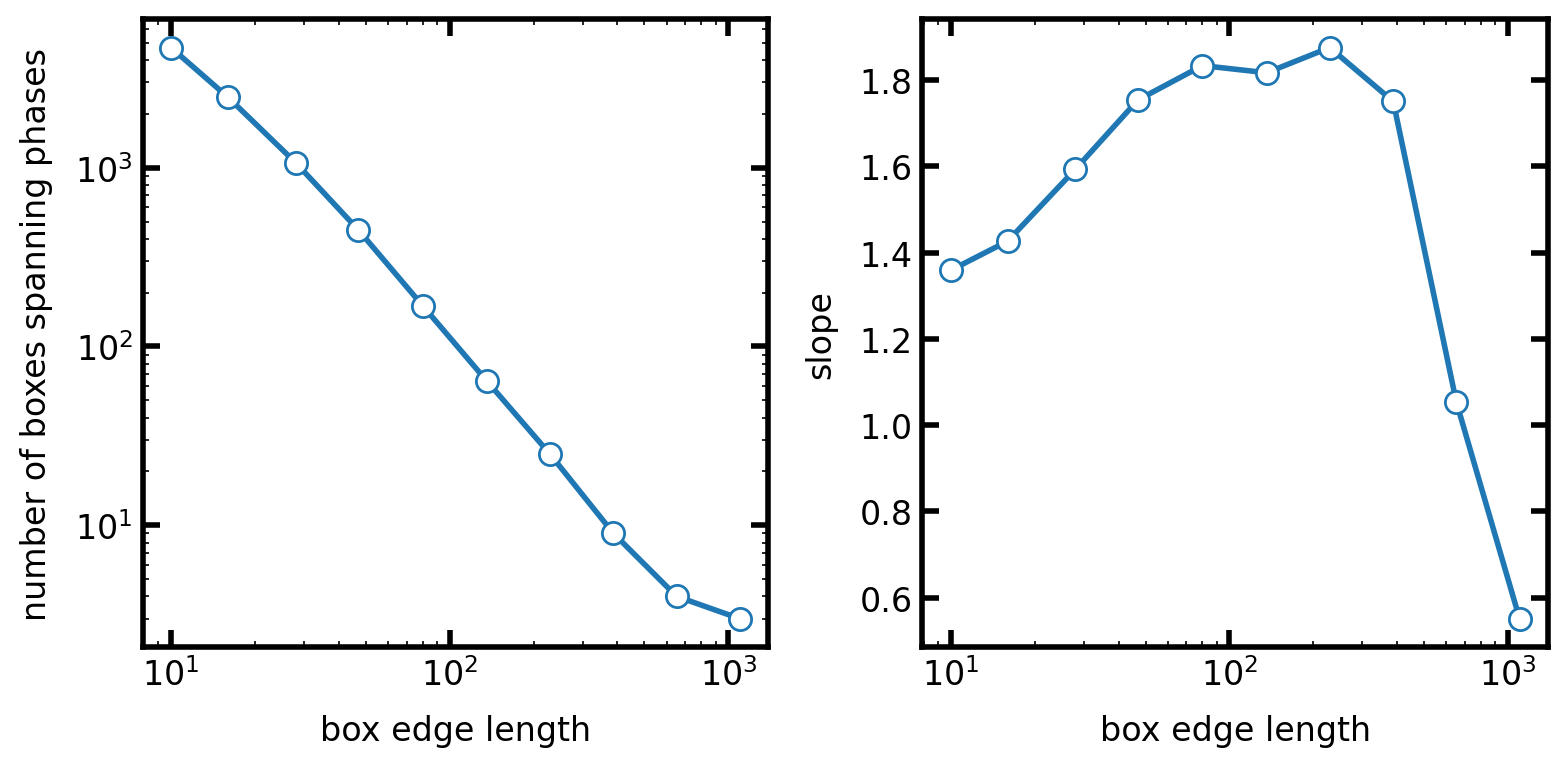

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('box edge length')
ax1.set_ylabel('number of boxes spanning phases')
ax2.set_xlabel('box edge length')
ax2.set_ylabel('slope')
ax2.set_xscale('log')
ax1.plot(data.size, data.count, '-o')
ax2.plot(data.size, data.slope, '-o');

## Lineal path

Mede tamanho e continuidade dos poros, quão contínua é cada fase ao longo de uma dimensão
Teoricamente, decaimento lento de L2(r) indica poros longos e conectados.

<Axes: >

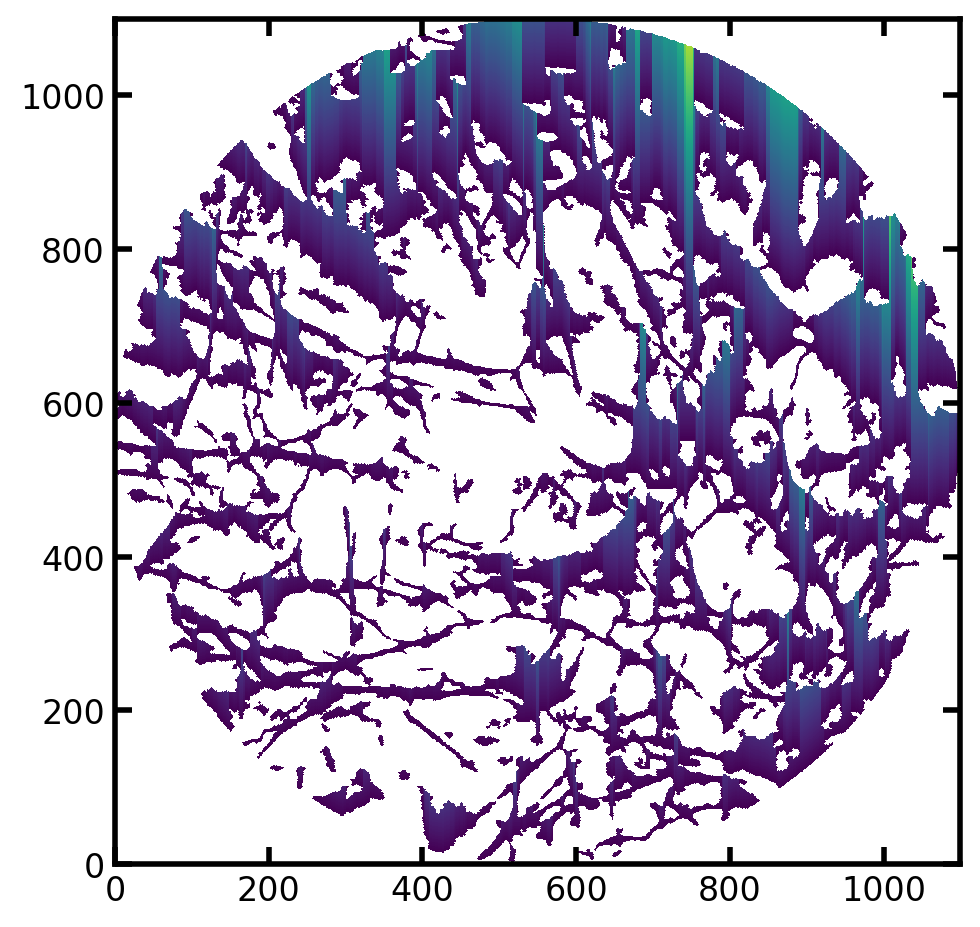

In [22]:
paths = ps.filters.distance_transform_lin(img, mode = 'forward', axis = 0)
ps.imshow(paths)

In [23]:
lpd = ps.metrics.lineal_path_distribution(paths, bins=range(1,200, 10))

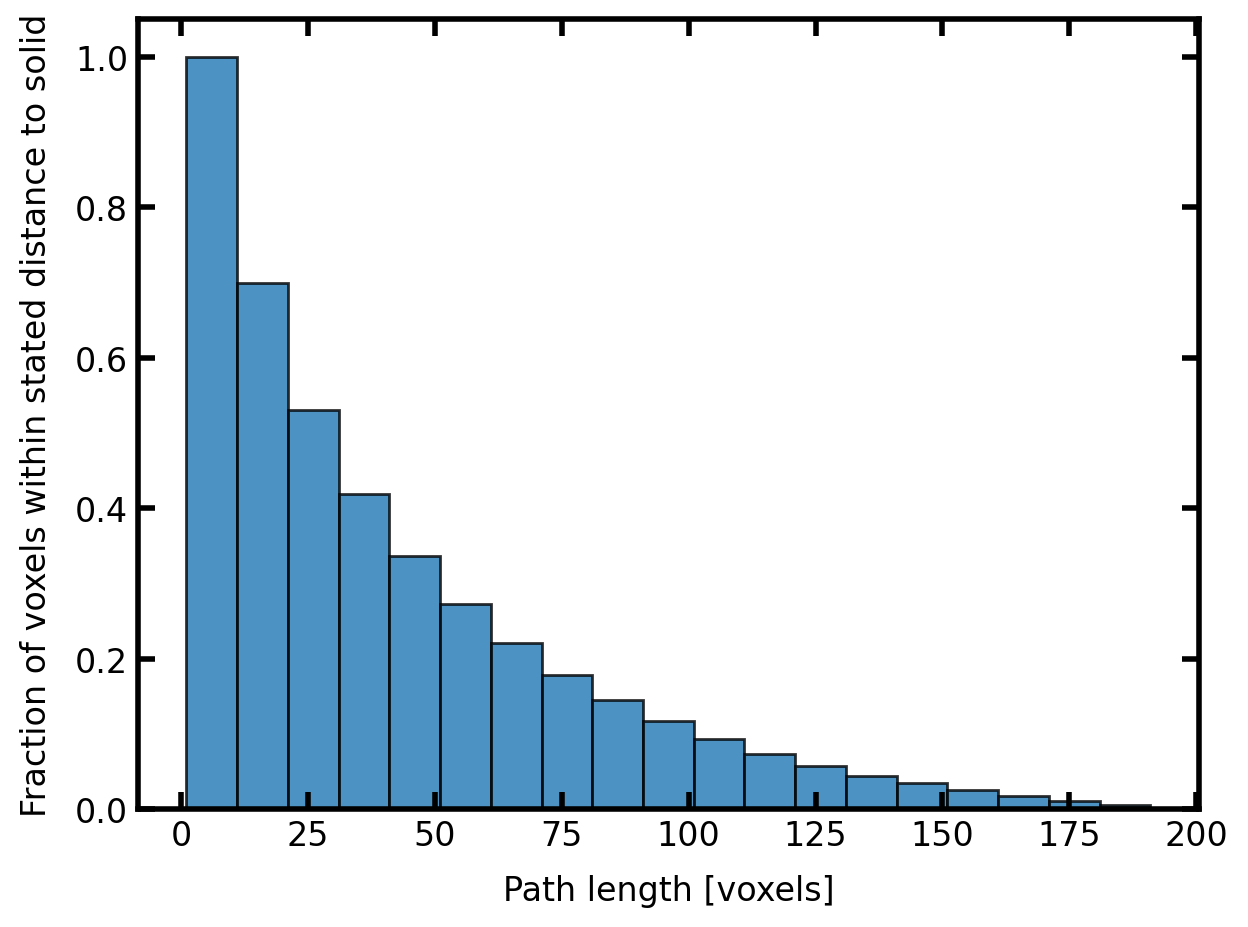

In [24]:
fig, ax = plt.subplots(1,1)
ax.bar(x=lpd.L, height=lpd.cdf, width=lpd.bin_widths, edgecolor='k', alpha=0.8)
ax.set_xlabel('Path length [voxels]')
ax.set_ylabel('Fraction of voxels within stated distance to solid');

## Porosity profile
Calcula como a porosidade muda ao longo dos eixos (individualmente, x, y, z). Detecta gradientes estruturais.

In [48]:
voxel_size = 1.34 # microns/voxel -> alterar

In [42]:
print("Stack shape:", stack.shape)

Stack shape: (100, 1100, 1100)


In [43]:
from skimage import transform

target_shape = (200, 300, 400)
stack_resized = transform.resize(stack, target_shape, order=1, preserve_range=True)

print(stack_resized.shape)

(200, 300, 400)


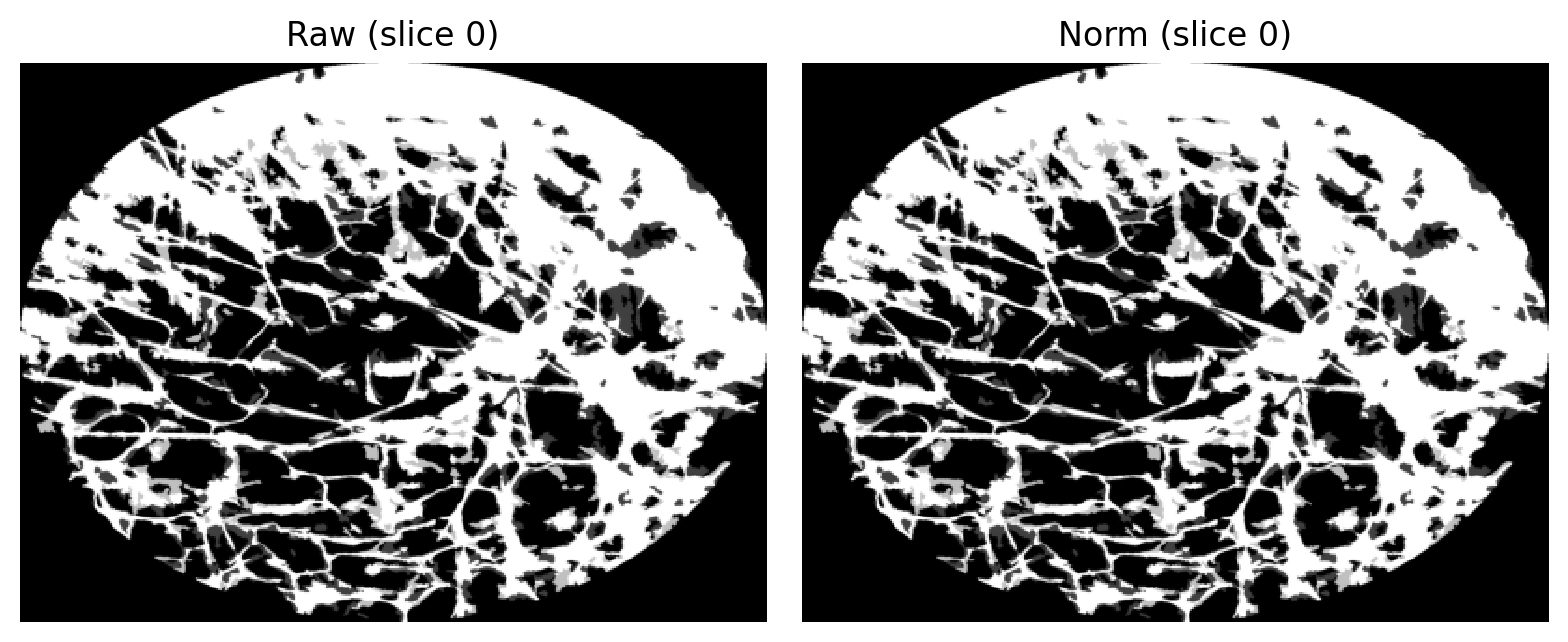

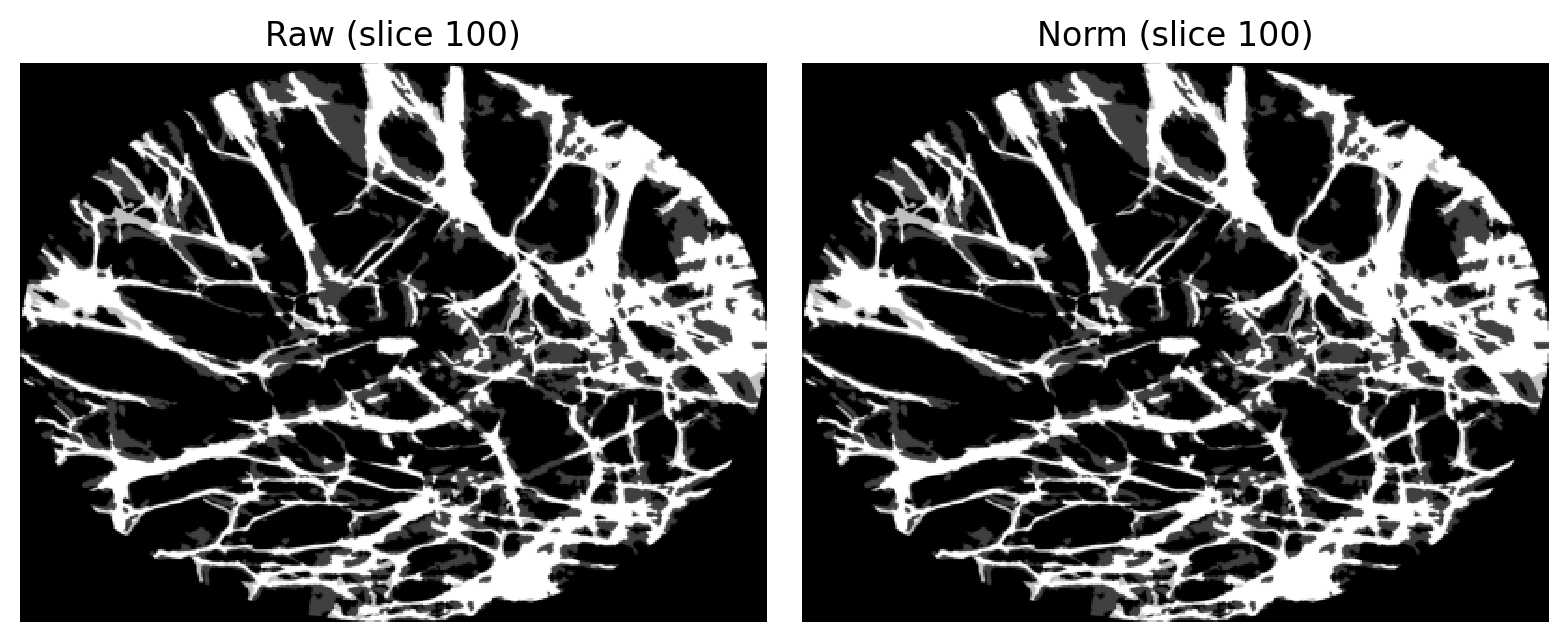

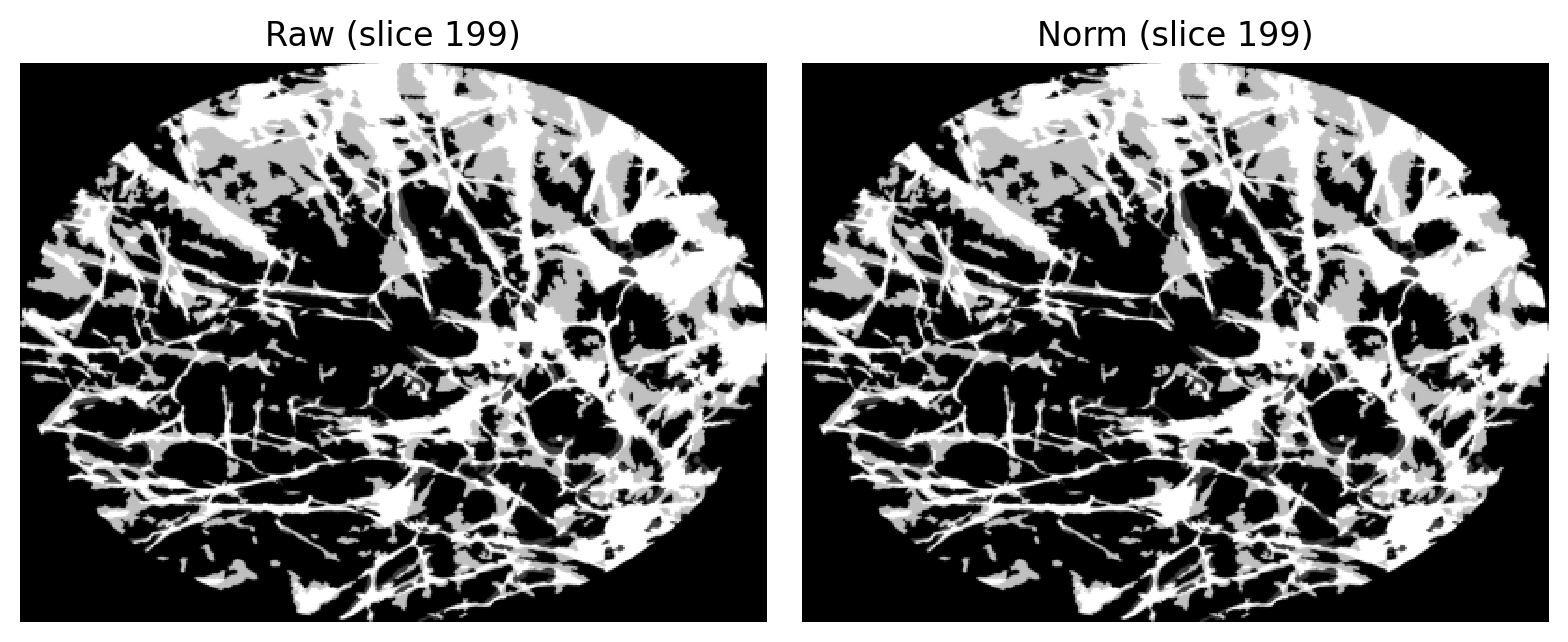

In [44]:
ids2 = [0, stack_resized.shape[0]//2, stack_resized.shape[0]-1]
for sid2 in ids2:
    im = stack_resized[sid2]

    stack_min = stack_resized.min()
    stack_max = stack_resized.max()
    im_norm = (im - stack_min) / (stack_max - stack_min)
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(im, cmap="gray")
    axes[0].set_title(f"Raw (slice {sid2})")
    axes[0].axis("off")
    
    axes[1].imshow(im_norm, cmap="gray")
    axes[1].set_title(f"Norm (slice {sid2})")
    axes[1].axis("off")
    
    plt.show()

In [45]:
x_profile = ps.metrics.porosity_profile(stack_resized, axis=0)
y_profile = ps.metrics.porosity_profile(stack_resized, axis=1)
z_profile = ps.metrics.porosity_profile(stack_resized, axis=2)

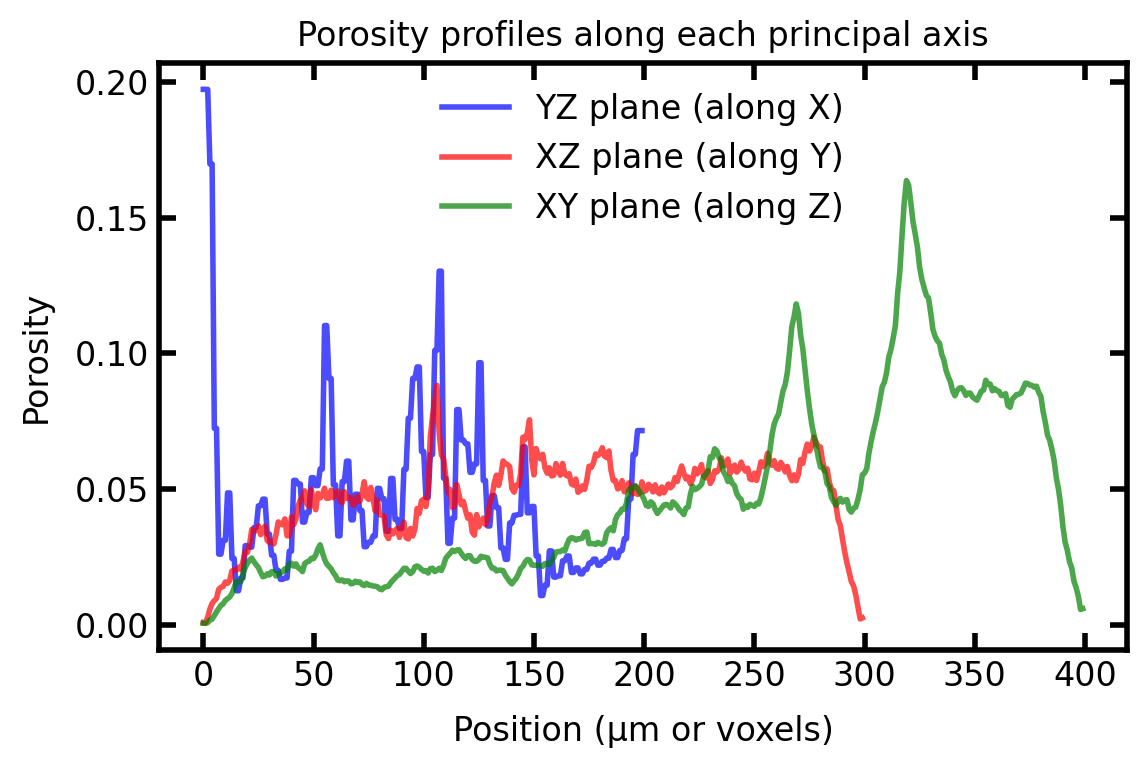

In [49]:
import matplotlib.pyplot as plt
import numpy as np

voxel_size = 1.0  # substitua pelo tamanho real do voxel se souber (ex: 2e-6 m)

positions_x = np.arange(len(x_profile)) * voxel_size
positions_y = np.arange(len(y_profile)) * voxel_size
positions_z = np.arange(len(z_profile)) * voxel_size

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(positions_x, x_profile, 'b-', label='YZ plane (along X)', alpha=0.7)
ax.plot(positions_y, y_profile, 'r-', label='XZ plane (along Y)', alpha=0.7)
ax.plot(positions_z, z_profile, 'g-', label='XY plane (along Z)', alpha=0.7)

ax.set_xlabel("Position (µm or voxels)")
ax.set_ylabel("Porosity")
ax.set_title("Porosity profiles along each principal axis")
ax.legend()
plt.show()

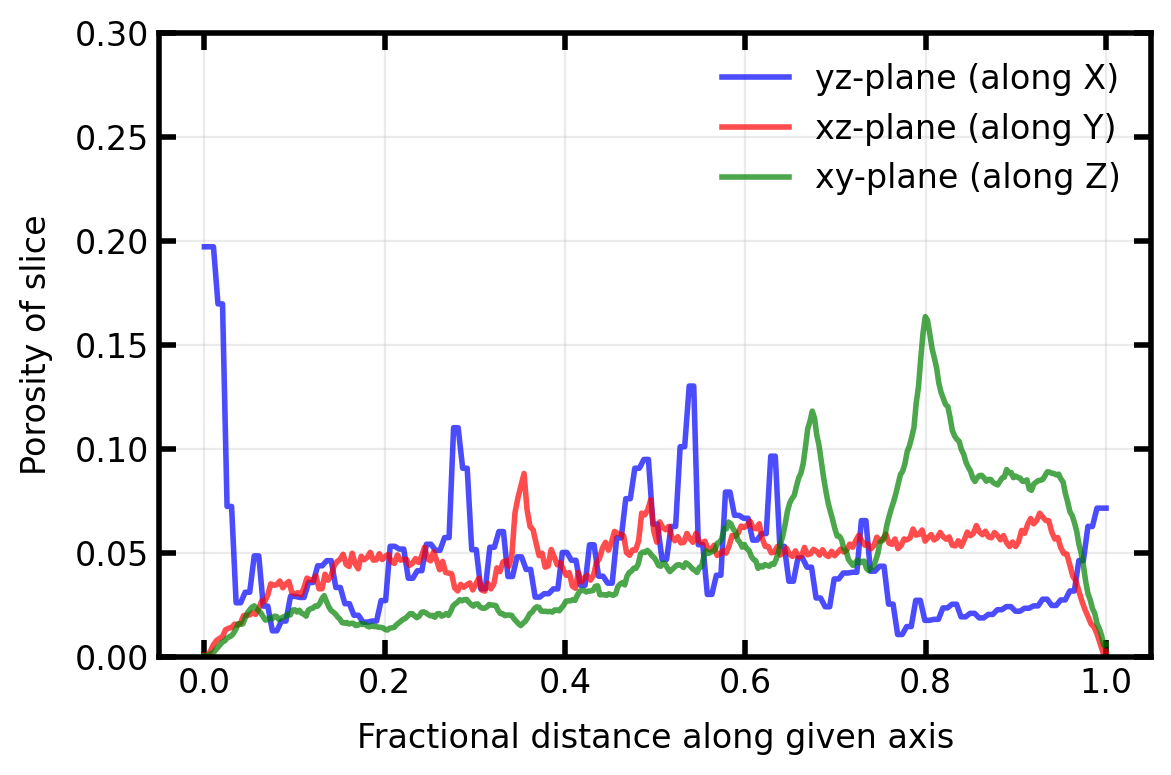

In [58]:
volume = stack_resized 

profiles = {}
if volume.ndim == 3:
    profiles['x'] = ps.metrics.porosity_profile(volume, axis=0)  # fatias YZ (varia em X)
    profiles['y'] = ps.metrics.porosity_profile(volume, axis=1)  # fatias XZ (varia em Y)
    profiles['z'] = ps.metrics.porosity_profile(volume, axis=2)  # fatias XY (varia em Z)
elif volume.ndim == 2:
    profiles['x'] = ps.metrics.porosity_profile(volume, axis=0)  # colunas -> varia em 0
    profiles['y'] = ps.metrics.porosity_profile(volume, axis=1)  # linhas  -> varia em 1
else:
    raise ValueError("Entrada deve ser 2D ou 3D")

# Constrói vetores de posição e normaliza pela extensão (fractional distance)
positions = {}
for key, arr in profiles.items():
    n = len(arr)
    pos = np.arange(n, dtype=float)            # 0,1,...,n-1 (em voxels)
    pos_frac = pos / pos.max() if pos.max() != 0 else pos  # normaliza para [0,1]
    positions[key] = pos_frac

fig, ax = plt.subplots(figsize=(6,4))

if 'x' in profiles:
    ax.plot(positions['x'], profiles['x'], 'b-', label='yz-plane (along X)', alpha=0.7)
if 'y' in profiles:
    ax.plot(positions['y'], profiles['y'], 'r-', label='xz-plane (along Y)', alpha=0.7)
if 'z' in profiles:
    ax.plot(positions['z'], profiles['z'], 'g-', label='xy-plane (along Z)', alpha=0.7)

ax.set_ylim([0, 0.3])
ax.set_ylabel('Porosity of slice')
ax.set_xlabel('Fractional distance along given axis')
ax.legend()
ax.grid(alpha=0.25)
plt.tight_layout()
plt.show()

## Using regionprops_3d to analyze properties of each pore
Usa o algoritmo SNOW para identificar os poros (conectados), regionprops para quantificar o tamanho, forma e posição dos poros.

In [60]:
snow = ps.filters.snow_partitioning(im = img)
regions = snow.regions*snow.im

0it [00:00, ?it/s]

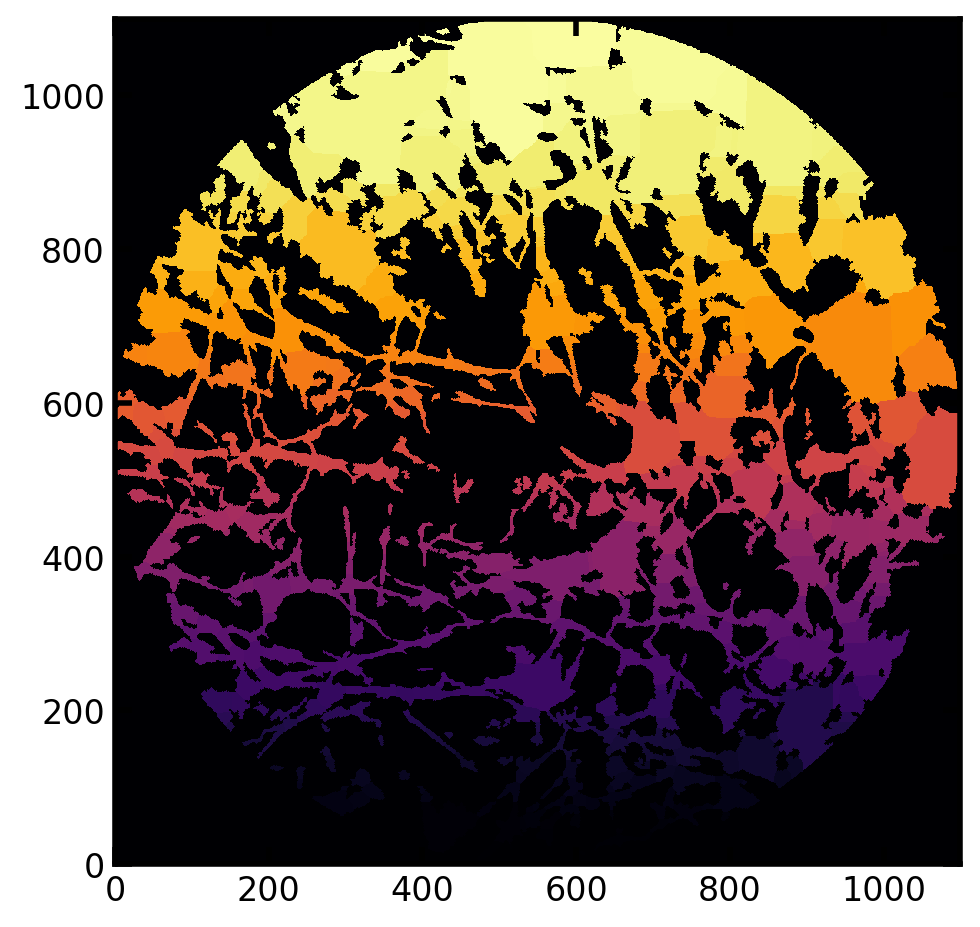

In [66]:
fig, ax = plt.subplots()

ax.imshow(regions, cmap=plt.cm.inferno)

In [67]:
props = ps.metrics.regionprops_3D(regions)

In [68]:
r = props[3]
attrs = [a for a in r.__dir__() if not a.startswith('_')]
print(attrs)

['label', 'slice', 'mask', 'slices', 'volume', 'bbox_volume', 'border', 'dt', 'inscribed_sphere', 'sphericity', 'skeleton', 'surface_area', 'surface_mesh_vertices', 'surface_mesh_simplices', 'convex_volume', 'num_pixels', 'area', 'bbox', 'area_bbox', 'centroid', 'area_convex', 'image_convex', 'coords_scaled', 'coords', 'eccentricity', 'equivalent_diameter_area', 'euler_number', 'extent', 'feret_diameter_max', 'area_filled', 'image_filled', 'image', 'inertia_tensor', 'inertia_tensor_eigvals', 'image_intensity', 'centroid_local', 'intensity_max', 'intensity_mean', 'intensity_min', 'intensity_std', 'axis_major_length', 'axis_minor_length', 'moments', 'moments_central', 'moments_hu', 'moments_normalized', 'orientation', 'perimeter', 'perimeter_crofton', 'solidity', 'centroid_weighted', 'centroid_weighted_local', 'moments_weighted', 'moments_weighted_central', 'moments_weighted_hu', 'moments_weighted_normalized']


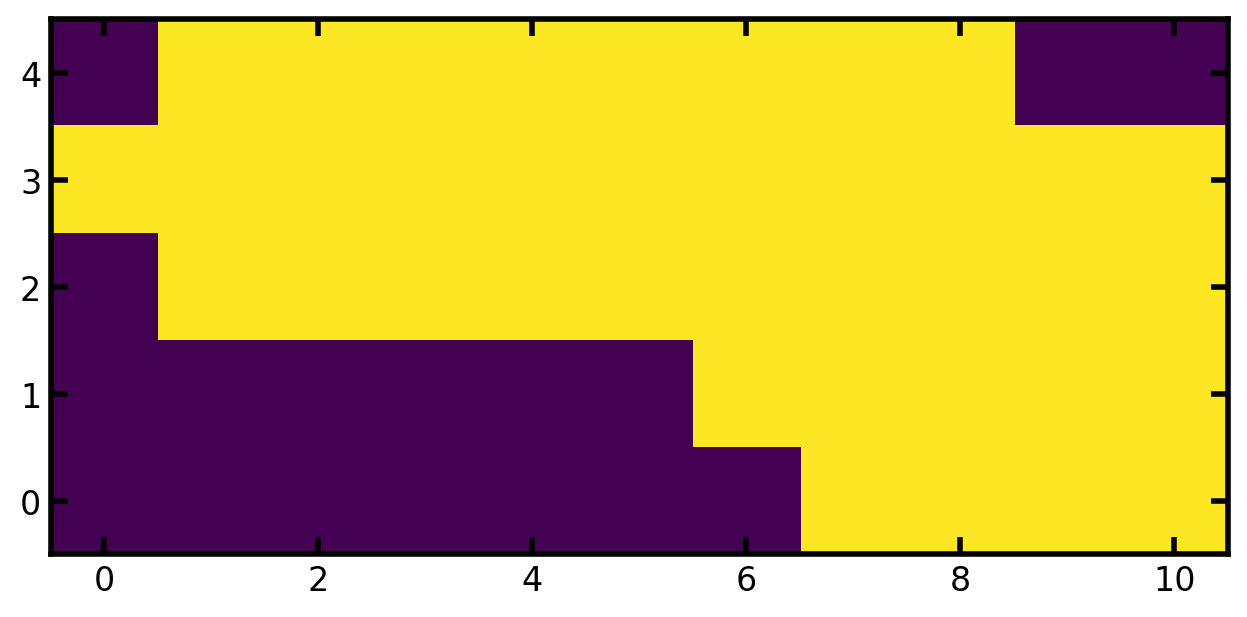

In [69]:
fig, ax = plt.subplots()
ax.imshow(r.image)

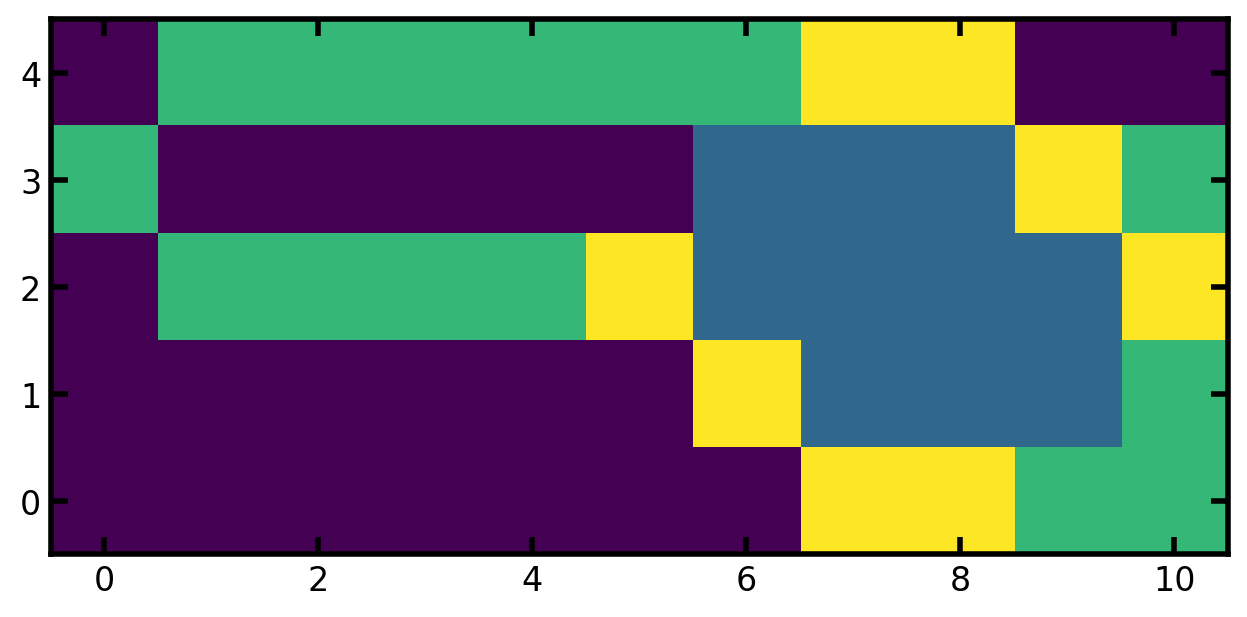

In [70]:
fig, ax = plt.subplots()
ax.imshow(r.border + 0.5*r.inscribed_sphere);

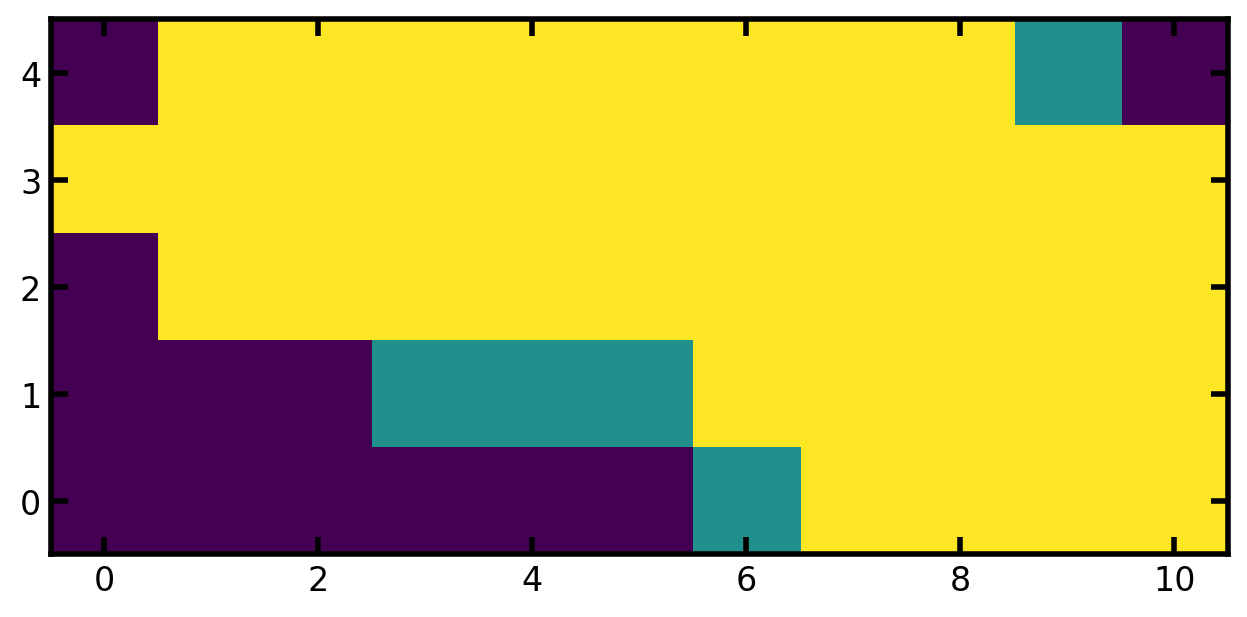

In [71]:
fig, ax = plt.subplots()
ax.imshow(r.image + 1.0*r.convex_image);

In [72]:
df = ps.metrics.props_to_DataFrame(props)

/mnt/bgfs/projects/tomo_nano/envs/tomo/lib/python3.9/site-packages/porespy/metrics/_regionprops.py:277: FutureWarning: `skeletonize_3d` is deprecated since version 0.23 and will be removed in version 0.25. Use `skimage.morphology.skeletonize` instead.
  return skeletonize_3d(self.mask)


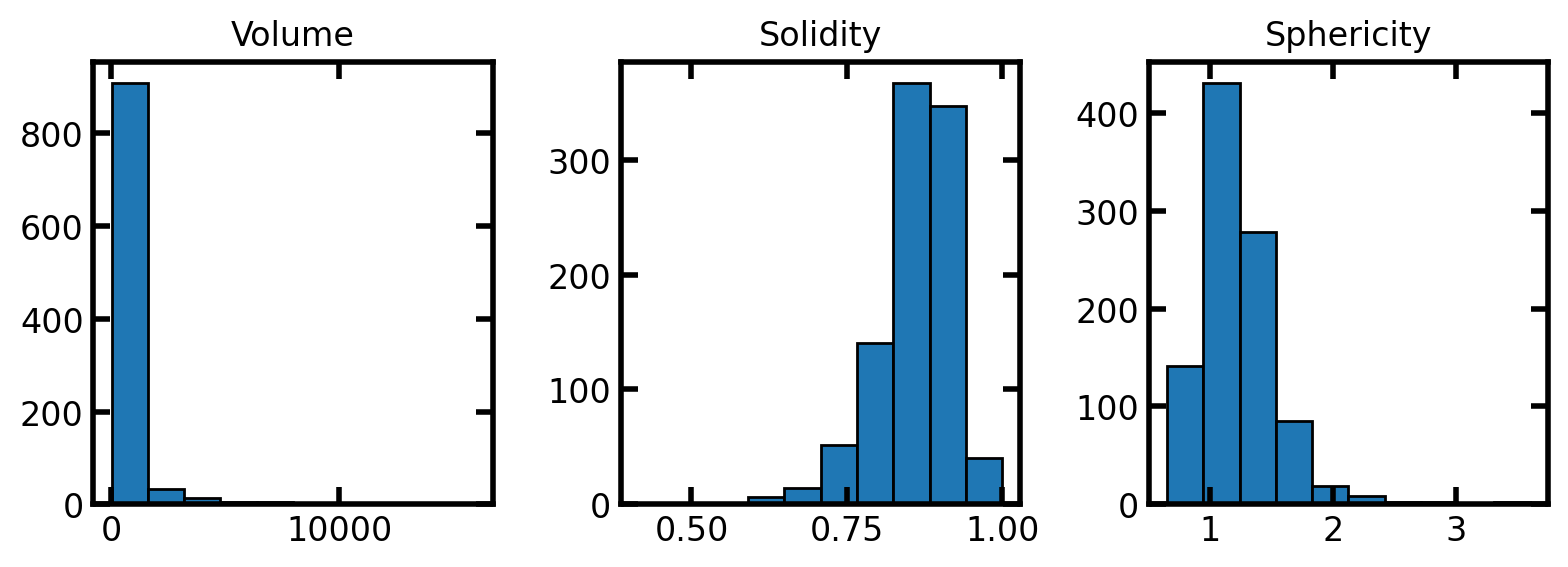

In [73]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3))
ax[0].hist(df['volume'], edgecolor="k")
ax[1].hist(df['solidity'], edgecolor="k")
ax[2].hist(df['sphericity'], edgecolor="k")
ax[0].set_title("Volume")
ax[1].set_title("Solidity")
ax[2].set_title("Sphericity");

In [74]:
df.iloc[0]

label                         1.000000
volume                      127.000000
bbox_volume                 200.000000
sphericity                    1.026083
surface_area                119.079567
convex_volume               147.000000
num_pixels                  127.000000
area                        127.000000
area_bbox                   200.000000
area_convex                 147.000000
eccentricity                  0.924971
equivalent_diameter_area     12.716187
euler_number                  1.000000
extent                        0.635000
feret_diameter_max           20.223748
area_filled                 127.000000
axis_major_length            21.154264
axis_minor_length             8.039405
orientation                   0.134254
perimeter                    53.941125
perimeter_crofton            53.820911
solidity                      0.863946
Name: 0, dtype: float64